# Contextual Bandits

The contextual bandit is a generalization of the multi-armed bandit. The agent still has to decide between $k$ arms at each iteration. However, they also have a $d$-dimensional feature vector (the "context") which is assumed to be related to the reward of the action.

The aim of the agent is to gain information about how the context and the reward are related to each other, so that over time it can choose the arm given a context that maximizes reward.

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

from number_bandit import NumberBandit

## Captcha Solver

In this simple example we train an agent to solve captchas (see folder captcha/). The captchas are taken from MNIST and to speed up training, we only take into account the numbers 0, 1, and 2.

In [2]:
NUM_NUM = 3

### Instantiation of the NumberBandit

We instantiate one Bandit per possible outcome / action (here 3 in order to speed up calculations).

During initialization, it creates a very simple Keras (fully connected) neural network.

In addition, it has the following to methods:
* train_net: take set of images and their respective reward and train the neural network
* make_prediction: takes one image and returns a prediction.

What do we actually fit / predict?
Let's say we consider the bandit for the number 2. This means when we hand the fit algorithm some image plus the reward that we got for the prediction "2". In case this image really showed a "2", the reward would be "1", otherwise "0". This means the prediction is between 0 and 1 and is the prediction for a given image to resemble a "2".

In [3]:
bandits = {i: NumberBandit() for i in range(NUM_NUM)};

2022-02-06 17:59:49.127495: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### A simple $\epsilon$-greedy algorithm

In every iteration, the agent has to choose between the possible actions. Here, we use a simple $\epsilon$-greedy algorithm.

This means in every iteration, we choose randomly ("exploration") with a probability of $\epsilon$. Otherwise, we choose greedily ("exploitation"), i.e. we choose the action for which we expect the highest reward.

In [4]:
def greedy_choice(bandits, img):
    probabilities = {i: bandit.make_prediction(np.atleast_2d(img))[0][0] for i, bandit in bandits.items()}
    return max(probabilities, key=probabilities.get)

def epsilon_greedy(epsilon, data):
    if np.random.random() > epsilon:
        action = greedy_choice(bandits, data)
    else:
        action = np.random.randint(0, NUM_NUM)
    return action

### Start learning...

We will now start learning...

In every step, we retrieve a captcha and choose an action following the $\epsilon$-greedy algorithm. We will store the images, our choices and the corresponding reward and update our model every 50 iterations.

In [5]:
def make_n_steps(n, epsilon=0.1):
    for n in range(n):
        captcha = requests.get("http://localhost:5000/captcha").json()
        data = np.array(captcha["data"])
        action = epsilon_greedy(epsilon, data)
        reward = requests.post(f"http://localhost:5000/captcha/{captcha['id']}/response/{action}").json()["reward"]
        train_batch[action]["imgs"].append(data)
        train_batch[action]["rewards"].append(reward)
        regrets.append(1 - reward)

        if (n % 50 == 0) & (n!=0):
            for i in range(NUM_NUM):
                if len(train_batch[i]["imgs"]) == 0: continue
                bandits[i].train_net(np.array(train_batch[i]["imgs"]), np.array(train_batch[i]["rewards"]))
        if (n % 100 == 0) & (n!=0):
            clear_output(wait=True)
            plt.plot(np.cumsum(regrets))
            plt.show()

In [6]:
train_batch = {}
for i in range(NUM_NUM):
    train_batch[i] = {"imgs": [], "rewards": []}

regrets = []

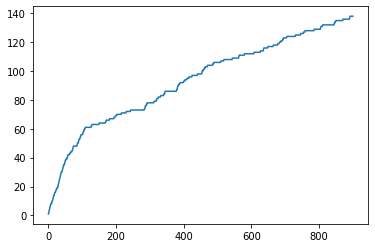

In [7]:
%matplotlib inline

make_n_steps(1000)

### Regret analysis

Let's analyze the regret function:
* In the beginning, we don't have any prior knowledge but use the default initialization of our model (which does not necessarily mean that we sample randomly: it would be more efficient to do exploration only at the beginning). This means, we have a 1/3 chance to guess the right number or a regret of $2/3 \times iteration$.
* Assuming that we have the perfect model, since we have a simple $\epsilon$-greedy approach, we would still do exploration with probability $\epsilon$, in which case we will be wrong with probability 2/3. This means our regret will increase with $\epsilon \times 2/3 \times iteration$.

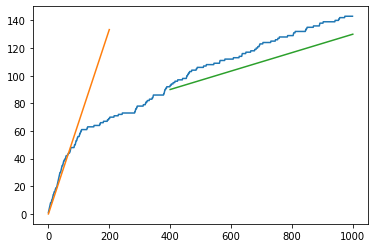

In [8]:
plt.plot(np.cumsum(regrets))
plt.plot([0, 200], [0, 200 * 2/3])
plt.plot([400+0, 400+600], [90+0, 90+600 * 2/30])